# Types of recommendations

There are mainly 6 types of the recommendations systems :-

1. Popularity based systems :- It works by recommeding items viewed and purchased by most people and are rated high.It is not a personalized recommendation.
2. Classification model based:- It works by understanding the features of the user and applying the classification algorithm to decide whether the user is     interested or not in the prodcut.
3. Content based recommedations:- It is based on the information on the contents of the item rather than on the user opinions.The main idea is if the user likes an item then he or she will like the "other" similar item.
4. Collaberative Filtering:- It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types:
 a) User-User 
 b) Item -Item
 
5. Hybrid Approaches:- This system approach is to combine collaborative filtering, content-based filtering, and other approaches . 
6. Association rule mining :- Association rules capture the relationships between items based on their patterns of co-occurrence across transactions.



In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv


Note : For any business to create recommendation system we need data. This data can be extracted in 2 ways:
1. Get the data from Similar businesses, given that the envirounment/interaction of user doesn't change with the products, even though the system changes
2. Get the data from our business, by recording how user is behaving with the data etc.

->  No matter the case initally a business should undergo live run without recommender system, collect the data for a certain period of time till the domain expert belives. Then use the data to create a system.
->Now we have items, their ratings, their intrinsic and extrinsic features. These can be used to create a sysetm

There are mainly 4 ways of Recommendation Systems :
1. Popularity Based
2. Collaborative Based ->Can be used to solve the cold-start problem of the user.
3. Content based -> Can be used effictively once a user had completed certain time on the website
4. Hybrid -> Using both of them

->It's important to note that using both together in conjunction will yield better results. ML systems when used with web-technologies properly can be very effective.

In [23]:
data = pd.read_csv("/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [24]:
data.head(5)

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [25]:
data.shape

(7824482, 4)

In [27]:
print("Total Users :",data["userId"].unique().shape[0])
print("Total User-Item Mappings",data.shape[0])
print("Average per user records",data.shape[0]/data["userId"].unique().shape[0])
print("Average per Item records",data.shape[0]/data["productId"].unique().shape[0])

Total Users : 4201696
Total User-Item Mappings 7824482
Average per user records 1.8622199226217222
Average per Item records 16.43791832807425


# Attribute Information:

● userId : Every user identified with a unique id 

● productId : Every product identified with a unique id 

● Rating : Rating of the corresponding product by the corresponding user 

● timestamp : Time of the rating ( ignore this column for this exercise)



In [28]:
oldData = data

In [29]:
oldData.shape[0]

7824482

In [78]:
data = oldData[:1000000]
#data = oldData

In [79]:
data.shape

(1000000, 4)

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
userId       1000000 non-null object
productId    1000000 non-null object
Rating       1000000 non-null float64
timestamp    1000000 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 30.5+ MB


In [81]:
data.describe()["Rating"]

count    1000000.000000
mean           3.973620
std            1.399741
min            1.000000
25%            3.000000
50%            5.000000
75%            5.000000
max            5.000000
Name: Rating, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7e45b2e6bf28>,
 'caps': [<matplotlib.lines.Line2D at 0x7e45b2af7630>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e45b2e6bdd8>],
 'medians': [<matplotlib.lines.Line2D at 0x7e45b2af7cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e45b2b04048>],
 'means': []}

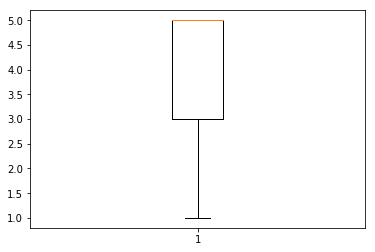

In [82]:
plt.boxplot(data["Rating"])

Most of the data has rating 5

In [83]:
#Checking for missing values
data.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

In [84]:
data.groupby("Rating").size()

Rating
1.0    122541
2.0     59519
3.0     79371
4.0    198917
5.0    539652
dtype: int64

In [85]:
type(data.groupby("Rating").size())

pandas.core.series.Series

In [86]:
groups = data.groupby("Rating").size()

<BarContainer object of 5 artists>

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Group Size by Rating')

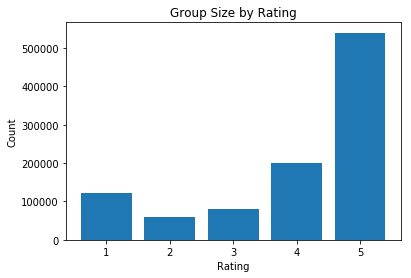

In [87]:
plt.bar(groups.index, groups.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Group Size by Rating')
plt.show()

In [88]:
print("Total Products", len(data))
print("Number of Users", data["userId"].unique().shape[0])
print("Number of Products", np.unique(data["productId"]).shape[0])

Total Products 1000000
Number of Users 754153
Number of Products 59634


In [90]:
products_per_user = data.groupby(by="userId")

In [91]:
products_per_user.size()

userId
A00038802J7X43YTW44TD    2
A000428226SAAAIBK8I36    1
A0004478EF5NFPHLGCWG     1
A000681618A3WRMCK53V     1
A00101847G3FJTWYGNQA     1
                        ..
AZZYXVW7BAJVD            1
AZZZBMD2MDOQR            1
AZZZEWADNFNUM            2
AZZZJXM9GW3C5            1
AZZZOVIBXHGDR            1
Length: 754153, dtype: int64

In [109]:
products_per_user.count().sort_values(by="Rating",ascending=True)

,productId,Rating,timestamp
userId,,,
A2W4B9IOKDJQ83,1,1,1
A3EJWKITVKJFP4,1,1,1
A3EJX1ZNN0TN02,1,1,1
A3EJXCEO1ZDTSG,1,1,1
A3EJXO61OKI6H5,1,1,1
...,...,...,...
AT6CZDCP4TRGA,125,125,125
A6FIAB28IS79,138,138,138
A25HBO5V8S8SEA,164,164,164


In [108]:
products_per_user.get_group("A00038802J7X43YTW44TD")

,userId,productId,Rating,timestamp
604495,A00038802J7X43YTW44TD,B0007NWLXO,1.0,1397433600
850057,A00038802J7X43YTW44TD,B000EGGPM2,5.0,1368662400


In [102]:
products_per_user["Rating"].count().sort_values(ascending=False)

userId
A5JLAU2ARJ0BO     409
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      138
AT6CZDCP4TRGA     125
                 ... 
A3EJXO61OKI6H5      1
A3EJXCEO1ZDTSG      1
A3EJX1ZNN0TN02      1
A3EJWKITVKJFP4      1
A2W4B9IOKDJQ83      1
Name: Rating, Length: 754153, dtype: int64

In [105]:
products_per_user.mean()

,Rating,timestamp
userId,,
A00038802J7X43YTW44TD,3.0,1.383048e+09
A000428226SAAAIBK8I36,5.0,1.388794e+09
A0004478EF5NFPHLGCWG,4.0,1.358381e+09
A000681618A3WRMCK53V,2.0,1.383610e+09
A00101847G3FJTWYGNQA,5.0,1.385770e+09
...,...,...
AZZYXVW7BAJVD,5.0,1.373414e+09
AZZZBMD2MDOQR,4.0,1.146096e+09
AZZZEWADNFNUM,3.5,9.963648e+08


In [113]:
X = products_per_user["productId"].count()

In [131]:
products_per_user["Rating"].get_group("AZZZOVIBXHGDR")

450609    1.0
Name: Rating, dtype: float64

In [132]:
products_per_user["Rating"].count()

userId
A00038802J7X43YTW44TD    2
A000428226SAAAIBK8I36    1
A0004478EF5NFPHLGCWG     1
A000681618A3WRMCK53V     1
A00101847G3FJTWYGNQA     1
                        ..
AZZYXVW7BAJVD            1
AZZZBMD2MDOQR            1
AZZZEWADNFNUM            2
AZZZJXM9GW3C5            1
AZZZOVIBXHGDR            1
Name: Rating, Length: 754153, dtype: int64

In [133]:
products_per_user["Rating"].count().describe()

count    754153.000000
mean          1.325991
std           1.372250
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         409.000000
Name: Rating, dtype: float64

In [148]:
products_per_item = data.drop(columns = ["timestamp","userId"]).groupby("productId")

In [149]:
products_per_item.size()

productId
0132793040      1
0321732944      1
0439886341      3
0511189877      6
0528881469     27
             ... 
B000HDOOO8      1
B000HDQ2G6    159
B000HDR8GO      1
B000HDRBIO      2
B000HDU0Q4     71
Length: 59634, dtype: int64

In [150]:
products_per_item.count()

,Rating
productId,
0132793040,1
0321732944,1
0439886341,3
0511189877,6
0528881469,27
...,...
B000HDOOO8,1
B000HDQ2G6,159
B000HDR8GO,1


In [151]:
products_per_item.get_group("0439886341")

,productId,Rating
2,0439886341,1.0
3,0439886341,3.0
4,0439886341,1.0


In [152]:
products_per_item.mean()

,Rating
productId,
0132793040,5.000000
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852
...,...
B000HDOOO8,3.000000
B000HDQ2G6,4.408805
B000HDR8GO,5.000000


In [156]:
#products_per_item.mean().sort_values(by="Rating")
products_per_item.mean()

,Rating
productId,
0132793040,5.000000
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852
...,...
B000HDOOO8,3.000000
B000HDQ2G6,4.408805
B000HDR8GO,5.000000


#Using the above table we can always recommend most popular item initially, we can use some advanced filters like sort by number of users who rated the product and the rating Id as a trade off 
and also remove products which has very few ratings